# Time-Series Forecasting using Machine Learning

This notebook is used to perform preliminary data analysis and forecasting of a power-load time-series. The aim of the present notebook is to provide a report on main features of a power-load series, that runs from 2006 to 2019. Then, one dives into the time-series forecasting, with a horizon of one year ahead.

## Libraries

The libraries used in this notebook are:

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np # type: ignore
import pandas as pd # type: ignore

# Plots
# ==============================================================================
import matplotlib.pyplot as plt # type: ignore
import plotly.graph_objects as go # type: ignore
import plotly.io as pio # type: ignore
import plotly.offline as poff # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore

pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor # type: ignore
from skforecast.ForecasterAutoreg import ForecasterAutoreg # type: ignore
from skforecast.model_selection import bayesian_search_forecaster # type: ignore
from skforecast.model_selection import backtesting_forecaster # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import shap # type: ignore
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Personal classes
# ==============================================================================
from my_app.functions.occupancySimulator import OccupancySimulator


## Step 1: data analysis

The first step is to analyse the dataset. This is [load.csv](/datasets/load.csv), containing a time-series of the power load (Wh) of an Italian building, covering a timespan from 2006-01-01 to 2022-02-07. The set only contains 2 columns and 5112 records, encoding the date of the record and the power load (Wh).

In [ ]:
# Loading the data
# ==============================================================================
data = pd.read_csv('datasets/data_with_occupants.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5113 non-null   object 
 1   Load       5113 non-null   float64
 2   occupants  5113 non-null   float64
 3   week_day   5113 non-null   int64  
 4   month      5113 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 199.9+ KB


Now one manipulates the data, converting the `Date` column to `datetime` format, and setting it as index. The frequeuency `1D` is specified as the data have been taken every 1 day. 

In [ ]:
# Data preparation
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data = data.asfreq('1D')
data = data.sort_index()
data.head(5) 

,Load,occupants,week_day,month
Date,,,,
2006-01-01,666542.0,0.0,7,1
2006-01-02,855403.0,0.0,1,1
2006-01-03,914705.0,96.0,2,1
2006-01-04,926705.0,123.0,3,1
2006-01-05,927560.0,70.0,4,1


Missing data are checked with frequency of 1 day, and if any, a not-a-number (`nan`) value is used for filling them. In this case, the time series is complete.

In [ ]:
# Verify that the time series is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

# if not complete, fill with NaN values
if data.isnull().any(axis=1).mean() > 0.0:
    data.asfreq(freq='1D', fill_value=np.nan)

Number of rows with missing values: 0.0


Since the ultimate aim is to provide a time-series forecasting, the data is divided into 2 sets: training and test. The testing of the forecasting model is performed with 2019 as a reference.

In [ ]:
# Split the remaining data into train-validation-test
# ==============================================================================
data = data.loc['2006-01-01': '2019-12-31'].copy()
start_train = '2006-01-01'
end_train = '2018-12-31'
start_test = '2019-01-01'
data_train = data.loc[start_train:end_train, :].copy()
data_test  = data.loc[start_test:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2006-01-01 00:00:00 --- 2018-12-31 00:00:00  (n=4748)
Test dates       : 2019-01-01 00:00:00 --- 2019-12-31 00:00:00  (n=365)


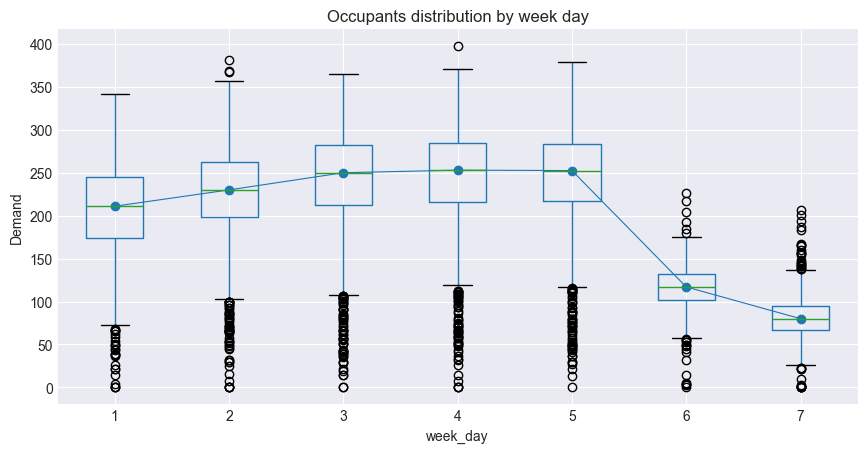

In [ ]:
# Occupants distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='occupants', by='week_day', ax=ax)
data.groupby('week_day')['occupants'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Occupants distribution by week day')
fig.suptitle('')
plt.show()

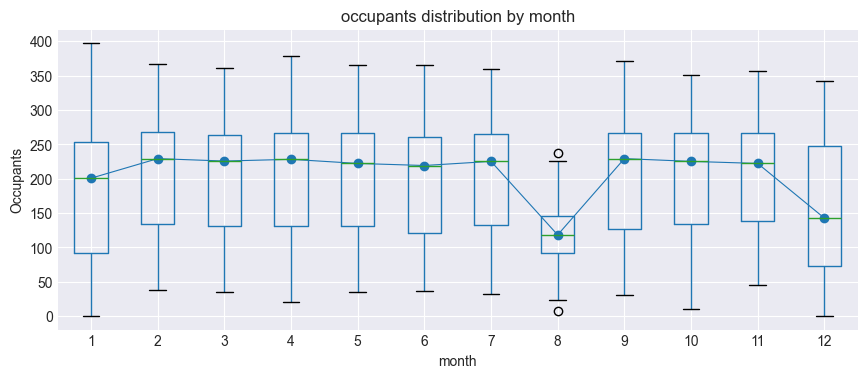

In [ ]:
# Load distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['month'] = data.index.month
data.boxplot(column='occupants', by='month', ax=ax,)
data.groupby('month')['occupants'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Occupants')
ax.set_title('occupants distribution by month')
fig.suptitle('')
plt.show()

In [ ]:
correlations = data.corr(method='pearson')
highly_correlated = abs(correlations[correlations > 0.5])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Load       occupants    0.663402
occupants  Load         0.663402


In [ ]:
import pickle
from my_app.functions.occupancySimulator import OccupancySimulator

lags = 2000
exog_features = ['occupants']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state= 15926, verbose= -1, min_child_samples=50, num_leaves=31),
                 lags      = lags
             ) 

forecaster.fit( y = data_train['Load'],
               exog=data_train[exog_features] )


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from my_app.functions.occupancySimulator import OccupancySimulator
from datetime import datetime, timedelta

""" simulator = OccupancySimulator( employees=400 )
dataNewOccupants = simulator.simulate_occupancy_future(start_date=data.index[-1]+timedelta(days=1), 
                                                       end_date=data.index[-1]+timedelta(days=steps+1), 
                                                       step=1 ) """


stepsGrid = range(1, 365)

# steps = 210

# PREDICTION STEP on TRAIN DATA --> to double check the OVERFITTING
end_train_overfitting  = '2017-12-31'
start_test_overfitting = '2018-01-01'
data_train_overfitting = data.loc[start_train:end_train_overfitting, :].copy()
data_test_overfitting  = data_train.loc[start_test_overfitting:end_train].copy()

r_squared_train_grid = []
r_squared_grid = []
mae_grid = []
mae_train_grid = []
for steps in stepsGrid:

    predTrain = forecaster.predict(
                            steps       = steps,
                            last_window = data_train_overfitting['Load'][-lags:],
                            exog        = data_test_overfitting[exog_features][:steps]
                    )

    # PREDICTION STEP
    pred = forecaster.predict(
                        steps       = steps,
                        last_window = data_train['Load'][-lags:],
                        exog        = data_test[exog_features][:steps]
                    )
    
    print( '---------------------------------' )
    print( '' )
    print(f'Steps: {steps}')

    # MEAN ABSOLUTE ERROR
    mae = mean_absolute_error(data_test['Load'].values[:steps], pred)
    print(f'Backtest error on test data (MAE): {mae}')

    mae_train = mean_absolute_error(data_train['Load'][-365:-365+steps], predTrain)
    print(f'Backtest error on train data (MAE): {mae}')

    # R-squared = 1 - MSE/Var(y) (MSE: Mean Squared Error; Var(y): variance of dependent variable y)
    r_squared = r2_score(data_test['Load'].values[:steps], pred)
    print(f'Backtest error on test data (R-squared): {r_squared}')

    r_squared_train = r2_score(data_train['Load'][-365:-365+steps], predTrain)
    print(f'Backtest error on train data (R-squared): {r_squared_train}')

    if r_squared_train < r_squared:
        print('Good! There is no overfitting.')
    else:
        print('There is overfitting (R2 for the train data is greater than the R2 for the test)')    
    
    mae_grid.append( mae )
    mae_train_grid.append( mae_train )

    r_squared_train_grid.append( r_squared_train )
    r_squared_grid.append( r_squared )

    print( '' )
    print( '---------------------------------' )


---------------------------------

Steps: 1
Backtest error on test data (MAE): 55334.99494634371
Backtest error on train data (MAE): 55334.99494634371
Backtest error on test data (R-squared): nan
Backtest error on train data (R-squared): nan
There is overfitting (R2 for the train data is greater than the R2 for the test)

---------------------------------
---------------------------------

Steps: 2
Backtest error on test data (MAE): 34671.310564268846
Backtest error on train data (MAE): 34671.310564268846
Backtest error on test data (R-squared): 0.7684437245093622
Backtest error on train data (R-squared): 0.9951472966548345
There is overfitting (R2 for the train data is greater than the R2 for the test)

---------------------------------
---------------------------------

Steps: 3
Backtest error on test data (MAE): 29152.237779682153
Backtest error on train data (MAE): 29152.237779682153
Backtest error on test data (R-squared): 0.8673878626374576
Backtest error on train data (R-squared

c:\Users\AndreaBellome\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

c:\Users\AndreaBellome\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



---------------------------------

Steps: 12
Backtest error on test data (MAE): 36541.26181844168
Backtest error on train data (MAE): 36541.26181844168
Backtest error on test data (R-squared): 0.8758442888565651
Backtest error on train data (R-squared): 0.992762573179395
There is overfitting (R2 for the train data is greater than the R2 for the test)

---------------------------------
---------------------------------

Steps: 13
Backtest error on test data (MAE): 35736.868694327764
Backtest error on train data (MAE): 35736.868694327764
Backtest error on test data (R-squared): 0.8800374207417638
Backtest error on train data (R-squared): 0.9926964432701585
There is overfitting (R2 for the train data is greater than the R2 for the test)

---------------------------------
---------------------------------

Steps: 14
Backtest error on test data (MAE): 33798.96166552998
Backtest error on train data (MAE): 33798.96166552998
Backtest error on test data (R-squared): 0.8851081207859823
Backtest 

In [ ]:
steps = 180

# PREDICTION STEP
pred = forecaster.predict(
                    steps       = steps,
                    last_window = data_train['Load'][-lags:],
                    exog        = data_test[exog_features][:steps]
                )

# MAX PERCENTAGE ERROR
y_true = data_test['Load'].values[:steps]
y_pred = pred
epsilon = np.finfo(float).eps
mape = np.max(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
print(f'Backtest error on test data (MAPE): {mape} %')

# MEAN ABSOLUTE ERROR
mae = mean_absolute_error(data_test['Load'].values[:steps], pred)
print(f'Backtest error on test data (MAE): {mae}')


# R-squared = 1 - MSE/Var(y) (MSE: Mean Squared Error; Var(y): variance of dependent variable y)
r_squared = r2_score(data_test['Load'].values[:steps], pred)
print(f'Backtest error on test data (R-squared): {r_squared}')

print(mae/np.max(data_test['Load'].values[:steps]))
print(mae/np.min(data_test['Load'].values[:steps]))


Backtest error on test data (MAPE): 21.722051627401587 %
Backtest error on test data (MAE): 28147.93637037625
Backtest error on test data (R-squared): 0.8816091335610498
0.02539457446782369
0.057314244210562824


In [ ]:
y_pred = pred
y_true = data_test['Load'].values[:steps]

residuals = np.abs(y_true - y_pred)
residual_std = np.std(residuals)

confidence_level = 0.95
z_score = 1.96  # for 95% confidence interval (2*sigma)

z_score = 1     # for 68.27% confidence interval (1*sigma)
margin_of_error = z_score * residual_std

lower_bounds_1 = y_pred - margin_of_error
upper_bounds_1 = y_pred + margin_of_error

between_bounds_count = np.sum((y_true >= lower_bounds_1) & (y_true <= upper_bounds_1))
percentage_within_bounds = (between_bounds_count / len(y_true)) * 100


z_score = 2     # for 68.27% confidence interval (1*sigma)
margin_of_error = z_score * residual_std
lower_bounds_2 = y_pred - margin_of_error
upper_bounds_2 = y_pred + margin_of_error

z_score = 3     # for 68.27% confidence interval (1*sigma)
margin_of_error = z_score * residual_std
lower_bounds_3 = y_pred - margin_of_error
upper_bounds_3 = y_pred + margin_of_error


print(percentage_within_bounds)

print(np.max(y_pred))
print(np.min(y_pred))
print(residual_std)


68.33333333333333
942904.207215579
540933.6840687887
30844.568067916527


In [ ]:

color = 'rgba(204, 0, 204,'
colorPred = '#FFCCCC'
colorTrue = '#330000'

# plot the results
fig = go.Figure([
    
    go.Scatter(
        name='Upper Bound',
        x=pred.index,
        y=upper_bounds_1,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=pred.index,
        y=lower_bounds_1,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor=color + '0.5)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Upper Bound',
        x=pred.index,
        y=upper_bounds_2,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=pred.index,
        y=lower_bounds_2,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor=color + '0.3)',
        fill='tonexty',
        showlegend=False
    )
    ,

    go.Scatter(
        name='Upper Bound',
        x=pred.index,
        y=upper_bounds_3,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=pred.index,
        y=lower_bounds_3,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor=color + '0.2)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Prediction',
        x=pred.index,
        y=pred,
        mode='lines',
        line=dict(color=colorPred)
    ),

    go.Scatter(
        name='Real value',
        x=data_test.index[:steps],
        y=data_test['Load'].values[:steps],
        mode='lines',
        line=dict(color=colorTrue)
    ),

])

fig.add_shape(
    type="line",
    x0=data_test.index[170],
    y0=0,
    x1=data_test.index[170],
    y1=1,
    xref='x',
    yref='paper',
    line=dict(color="black", width=2)
)

fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    ),
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()


In [68]:
# plot the results
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index[:steps], y=data_test['Load'].values[:steps], name="to predict", mode="lines")
trace2 = go.Scatter(x=pred.index, y=pred, name="prediction (default occupants)", mode="lines")

fig.add_trace(trace1)
fig.add_trace(trace2)

# Add vertical line
fig.add_shape(
    type="line",
    x0=data_test.index[170],
    y0=0,
    x1=data_test.index[170],
    y1=1,
    xref='x',
    yref='paper',
    line=dict(color="black", width=2)
)

fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()


In [105]:
# plot the results

fig = go.Figure()
trace1 = go.Scatter(x= list(stepsGrid), y=r_squared_grid, name="R2 on test data", mode="markers+lines",  marker=dict(symbol="circle", size=10) )

fig.add_trace(trace1)

# Add vertical line
fig.add_shape(
    type="line",
    x0=170,
    y0=0,
    x1=170,
    y1=1,
    xref='x',
    yref='paper',
    line=dict(color="black", width=2)
)

fig.update_layout(
    title="Accuracy",
    xaxis_title="Predicted steps",
    yaxis_title="R2",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    ),
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_yaxes(range=[0.6, 1])
fig.show()


In [16]:
# plot the results
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=pred.index, y=pred, name="prediction (default occupants)", mode="lines")

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [55]:
""" lags = 1850
steps = 365

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=15926, verbose=-1),
                lags      = lags
            )
forecaster
print(forecaster)

# Add exogenous features
# ==============================================================================
exog_features = ['occupants']

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'Load'], exog=data.loc[:end_train, exog_features])

# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['Load'],
                        exog               = data[exog_features],
                        steps              = steps,
                        metric             = 'mean_absolute_error', initial_train_size = len(data[:end_train]),
                        refit              = False, n_jobs = 'auto', verbose = False, show_progress = False
                    )

print(metric) """

" lags = 1850\nsteps = 365\n\n# Create forecaster\n# ==============================================================================\nforecaster = ForecasterAutoreg(\n                regressor = LGBMRegressor(random_state=15926, verbose=-1),\n                lags      = lags\n            )\nforecaster\nprint(forecaster)\n\n# Add exogenous features\n# ==============================================================================\nexog_features = ['occupants']\n\n# Train forecaster\n# ==============================================================================\nforecaster.fit(y=data.loc[:end_train, 'Load'], exog=data.loc[:end_train, exog_features])\n\n# Backtesting model\n# ==============================================================================\nmetric, predictions = backtesting_forecaster(\n                        forecaster         = forecaster,\n                        y                  = data['Load'],\n                        exog               = data[exog_features],\n      

Now perform the backtesting.

In [56]:

steps = 6*30

# Set the forecast horizon and the lags
# ==============================================================================
# lagsgrid = [100, 200, 300, 365, 500, 600, 700, 720, 800, 900, 365*3, 1000, 1850, 2000]
# lagsgrid = [1850]
lagsgrid = [ 365, 365*2, 1000, 1500, 1850, 2000, 2200, 2500, 3000, 3200, 3500 ]

wantExog = True

metricgrid = []
for lags in lagsgrid:

    # Create forecaster
    # ==============================================================================
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=15926, verbose=-1),
                    lags      = lags
                )

    # Add exogenous features
    # ==============================================================================
    exog_features = ['occupants']

    if wantExog:

        # Train forecaster
        # ==============================================================================
        forecaster.fit( y=data.loc[:end_train, 'Load'],
                        exog=data.loc[:end_train, exog_features] )

        # Backtesting model
        # ==============================================================================
        metric, predictions = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = data['Load'],
                                exog               = data[exog_features],
                                steps              = steps,
                                metric             = 'mean_absolute_error', initial_train_size = len(data[:end_train]),
                                refit              = False, n_jobs = 'auto', verbose = False, show_progress = False
                            )
        
    else:

        # Train forecaster
        # ==============================================================================
        forecaster.fit( y=data.loc[:end_train, 'Load'] )

        # Backtesting model
        # ==============================================================================
        metric, predictions = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = data['Load'],
                                steps              = steps,
                                metric             = 'mean_absolute_error', initial_train_size = len(data[:end_train]),
                                refit              = False, n_jobs = 'auto', verbose = False, show_progress = False
                            )
    
    metricgrid.append(metric)

    print('Lags: ' + str(lags) + ' Metric: ' + str(metric))


Lags: 365 Metric: 39593.65017903158
Lags: 730 Metric: 44863.39908520322


KeyboardInterrupt: 

In [ ]:

lagsmin = lagsgrid[np.argmin(metricgrid)]
print( lagsmin )

forecaster


2000


ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [   1    2    3 ... 3498 3499 3500] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3500 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['occupants'] 
Training range: [Timestamp('2006-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_k

TODO: Perform grid search over hyperparameters to improve the model accuracy

In [ ]:

# Set the forecast horizon and the lags
# ==============================================================================
lags = lagsmin

lagsGrid         = [ lagsmin ]
estimatorsGrid   = [ 800, 1000, 1200, 1300, 1400, 1500 ]
maxDepthGrid     = [ -1, 4, 5, 6, 7, 8, 9, 10 ]
learningRateGrid = [ 0.0100786818966835 ]
alphaGrid        = [0.1] # [ 0.0, 0.1, 0.2, 0.3 ]

metricgrid = []
paramsGrid = []
metricOpt  = np.Inf
for lags in lagsGrid:

    for estimators in estimatorsGrid:

        for depth in maxDepthGrid:

            for learningRate in learningRateGrid:

                for alpha in alphaGrid:

                    params = {
                        'n_estimators': estimators,
                        'max_depth': depth,
                        'learning_rate': learningRate,
                        'reg_alpha': alpha,
                        'reg_lambda': 0.0,
                        'random_state': 15926,
                        'verbose': -1
                    }

                    # Create forecaster
                    # ==============================================================================
                    forecaster = ForecasterAutoreg(
                                    regressor = LGBMRegressor(**params),
                                    lags      = lags
                                )

                    # Add exogenous features
                    # ==============================================================================
                    exog_features = ['occupants']

                    # Train forecaster
                    # ==============================================================================
                    forecaster.fit(y=data.loc[:end_train, 'Load'],
                                exog=data.loc[:end_train, exog_features])

                    # Backtesting model
                    # ==============================================================================
                    metric, predictions = backtesting_forecaster(
                                            forecaster         = forecaster,
                                            y                  = data['Load'],
                                            exog               = data[exog_features],
                                            steps              = steps,
                                            metric             = 'mean_absolute_error', initial_train_size = len(data[:end_train]),
                                            refit              = False, n_jobs = 'auto', verbose = False, show_progress = False
                                        )
                    
                    metricgrid.append(metric)
                    paramsGrid.append(params)
                    metricCurr = metric

                    # include a code here to save the best setup
                    if metricCurr < metricOpt:
                        paramsOpt = params


                    print('Lags: ' + str(lags) + ' Metric: ' + str(metric) + ' Estimators: ' + str(estimators) + ' Depth: ' + str(depth) + ' Learning rate: ' + str(learningRate) + ' Alpha: ' + str(alpha))

Lags: 2000 Metric: 31530.02242130586 Estimators: 800 Depth: -1 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 33023.91092299683 Estimators: 800 Depth: 4 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 32012.68150484682 Estimators: 800 Depth: 5 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 32293.453238406604 Estimators: 800 Depth: 6 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 32672.54328105064 Estimators: 800 Depth: 7 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 33016.85758099962 Estimators: 800 Depth: 8 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 31822.37652714642 Estimators: 800 Depth: 9 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 32223.434529668786 Estimators: 800 Depth: 10 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 30941.597118569312 Estimators: 1000 Depth: -1 Learning rate: 0.0100786818966835 Alpha: 0.1
Lags: 2000 Metric: 33015.00379

KeyboardInterrupt: 

In [ ]:

# these are optimal parameters for steps=1 (without exog)
params = {
    'n_estimators': 1200, # old was 1200
    'max_depth': 5, # old was 5
    'learning_rate': 0.0100786818966835, # old was 0.0100786818966835
    'reg_alpha': 0.1,  # old was 0.1
    'reg_lambda': 0.1, # old was 0.1
    'random_state': 15926,
    'verbose': -1
}

""" # these are optimal parameters for steps=365 (with exog)
params = {
    'n_estimators': 1000, # old was 1200
    'max_depth': -1, # old was 5
    'learning_rate': 0.0100786818966835, # old was 0.0100786818966835
    'reg_alpha': 0.1,  # old was 0.1
    'reg_lambda': 0.0, # old was 0.1
    'random_state': 15926,
    'verbose': -1
}

# these are optimal parameters for steps=180 (with exog)
params = {
    'n_estimators': 1000, # old was 1200
    'max_depth': -1, # old was 5
    'learning_rate': 0.0100786818966835, # old was 0.0100786818966835
    'reg_alpha': 0.1,  # old was 0.1
    'reg_lambda': 0.0, # old was 0.1
    'random_state': 15926,
    'verbose': -1
} """

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 1850
             )

# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Load'],
                          steps              = 1,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(metric)

  0%|          | 0/365 [00:00<?, ?it/s]

21579.712314528235


In [ ]:

lags = 1850

# these are optimal parameters for steps=1 (without exog)
params = {
    'n_estimators': 1200, # old was 1200
    'max_depth': 5, # old was 5
    'learning_rate': 0.0100786818966835, # old was 0.0100786818966835
    'reg_alpha': 0.1,  # old was 0.1
    'reg_lambda': 0.1, # old was 0.1
    'random_state': 15926,
    'verbose': -1
}

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 1850
             )

forecaster.fit( y = data_train['Load'],
               exog = data_train[exog_features] )


# PREDICTION STEP
pred = forecaster.predict(
                       steps       = steps,
                       last_window = data_train['Load'][-lags:],
                       exog        = data_test[exog_features]
                   )


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# TRAIN STEP
forecaster.fit( y = data_train['Load'],
               exog = data_train[exog_features] )

# PREDICTION STEP
pred = forecaster.predict(
                       steps       = steps,
                       last_window = data_train['Load'][-lags:],
                       exog        = data_test[exog_features]
                   )


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# MEAN ABSOLUTE ERROR
mae = mean_absolute_error(data_test['Load'].values[:steps], pred)
print(f'Backtest error (MAE): {mae}')

# R-squared = 1 - MSE/Var(y) (MSE: Mean Squared Error; Var(y): variance of dependent variable y)
r_squared = r2_score(data_test['Load'].values[:steps], pred)
print(f'Backtest error (R-squared): {r_squared}')

ValueError: Found input variables with inconsistent numbers of samples: [2, 1]

In [ ]:
# modify the exogenous variables and see how the prediction changes
data_test_copy = data_test.copy()
data_test_copy[exog_features] = 0.0

# PREDICTION STEP
pred_copy = forecaster.predict(
                       steps       = steps,
                       last_window = data_train['Load'][-lags:],
                       exog        = data_test_copy[exog_features]
                   )


# plot the results
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=pred.index, y=pred, name="prediction (default occupants)", mode="lines")
trace3 = go.Scatter(x=pred_copy.index, y=pred_copy, name="prediction (0 occupants)", mode="lines")

fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)

fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()


In [ ]:
import pickle

# SAVE THE FORECASTER
pickle.dump(forecaster, open('forecaster_params_exog_occ_steps_365.pkl', 'wb'))

C:\Users\AndreaBellome\AppData\Local\Temp\ipykernel_11540\1745029806.py:4: ResourceWarning:

unclosed file <_io.BufferedWriter name='forecaster_params_exog_occ_steps_365.pkl'>



In [ ]:
from sklearn.metrics import mean_absolute_error

# PREDICTION STEP
vector = data_train.loc[:, 'Load'].iloc[-1850:].values
exog   = data_train.loc[:, 'occupants'].iloc[-1851:].values

# pred = forecaster.predict(steps, data_train.loc[:, 'Load'].iloc[-1850:])
pred1 = forecaster.predict(steps, data_train.loc[:, 'Load'].iloc[-1850:],  data_test[exog_features] )

pred = forecaster._recursive_predict(steps=365, last_window=vector, exog=exog)
mae = mean_absolute_error(data_test['Load'].values, pred)
print(mae)

print(pred1)

""" print(data_test['Load'].values[0])
print(pred[0])
 """



32704.362152547717
2019-01-01    603731.068501
Freq: D, Name: pred, dtype: float64


" print(data_test['Load'].values[0])\nprint(pred[0])\n "

In [ ]:
from my_app.functions.dateConversion import DateConversion

# START: convert dates from datetime to numpy.array
converter = DateConversion()

X_train = data_train.index.strftime('%Y-%m-%d %H:%M:%S').values.reshape(-1, 1)  # Convert datetime index to numpy array
y_train = data_train['Load'].values

x_train_jd = np.array([])
for dates in X_train:
    date = dates[0]
    jd = converter.date2jd( date )

    x_train_jd = np.append(x_train_jd, jd)

print(x_train_jd)
print(y_train)
# END: convert dates from datetime to numpy.array



[2453736.5 2453737.5 2453738.5 ... 2458481.5 2458482.5 2458483.5]
[666542.      855403.      914705.      ... 629230.483   588404.06375
 618774.551  ]


In [ ]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


raw_seq = data_train[ 'Load' ].values

n_steps = 365
n_features = 1

X, y = split_sequence(raw_seq, n_steps)

X = X.reshape((X.shape[0], X.shape[1], n_features))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
import tensorflow as tf 

# define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

""" # train the model on the data
model.fit(X, y, epochs=1000, verbose=0) """


Num GPUs Available:  0


c:\Users\AndreaBellome\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



' # train the model on the data\nmodel.fit(X, y, epochs=1000, verbose=0) '

In [ ]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### Plot time series

In this section, graphical exploration is provided of the dataset. This allows to identify trends and patterns. The section first provides plots the full time series, providing some zoom on interesting areas, and then presents some seasonality plots.

To plot the time series, a `go.Figure()` object is created using the Plotly libray, that provides interactive plots by default. Train and test data are also represented in successive figure.

In [ ]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Load'], mode='lines', name='Load'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

An highlight of the train and test sets is also provided.

In [ ]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Load'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Load'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Power load (Wh)',
    xaxis_title="Time",
    yaxis_title="Load",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

From the graph one notices that the power load has annual seasonality. In particular, highest peaks occurr almost every July, while lowest peaks are shifted approximately 4 months one after the other (e.g., December/January to April, April to August, August to December/January). This is also shown in the following figure, zooming on a reference year (2018 in this case).

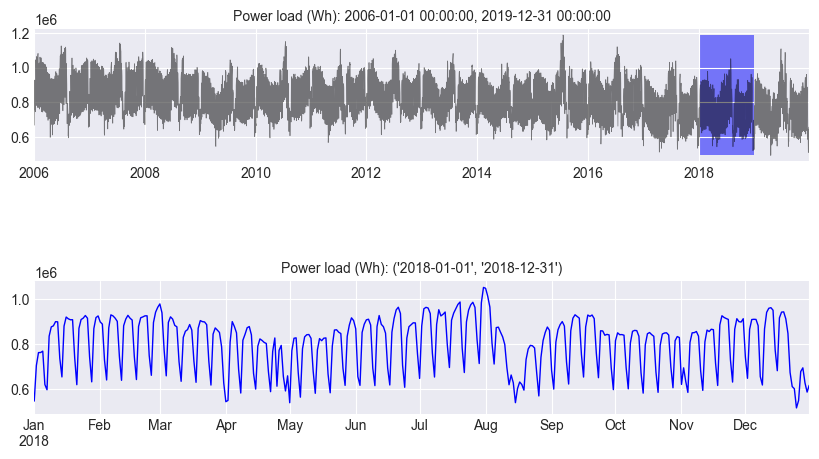

In [ ]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-12-31')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

A zoom is also provided on a reference short-term period (i.e., January-February span in 2018, in this case). This shows that the power load is cyclic with respect to the day of the week. In particular, since the 2018-01-01 was Sunday, the power load reaches its minimum roughly every 7 days, i.e., every weekend.

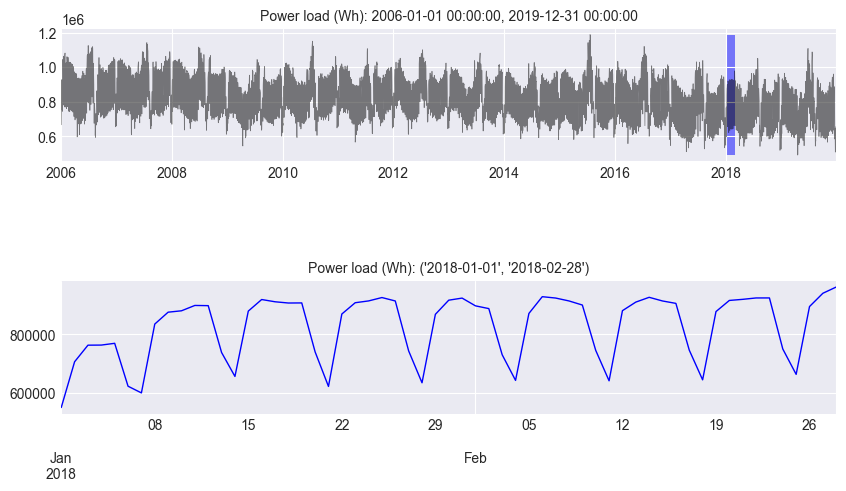

In [ ]:
# Zooming time series chart
# ==============================================================================
zoom = ('2018-01-01','2018-02-28')

fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Load.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Load)
max_y = max(data.Load)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Power load (Wh): {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Load.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Power load (Wh): {zoom}', fontsize=10)
zoom_ax.set_xlabel('')

plt.subplots_adjust(hspace=1)
plt.show()

### Seasonality plots

Seasonal plots are provided to identify seasonal patterns and trends in the series. This can be obtained with boxplots, that average the data over time.

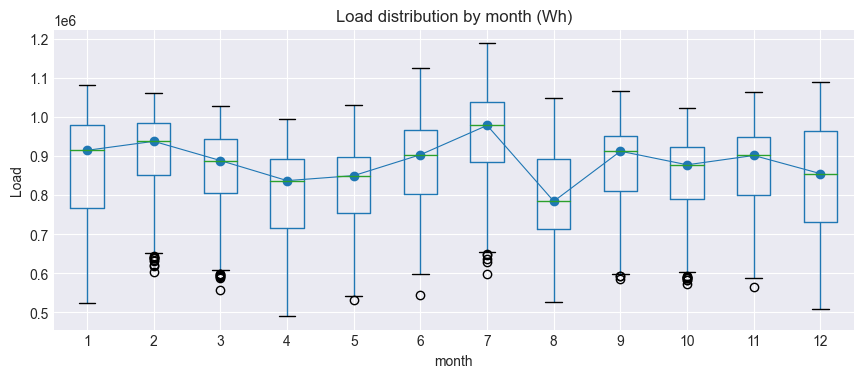

In [ ]:
# Load distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['month'] = data.index.month
data.boxplot(column='Load', by='month', ax=ax,)
data.groupby('month')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load')
ax.set_title('Load distribution by month (Wh)')
fig.suptitle('')
plt.show()

It is observed an annual peak in July, with minimum in August, possibly due to the summer-period vacations.

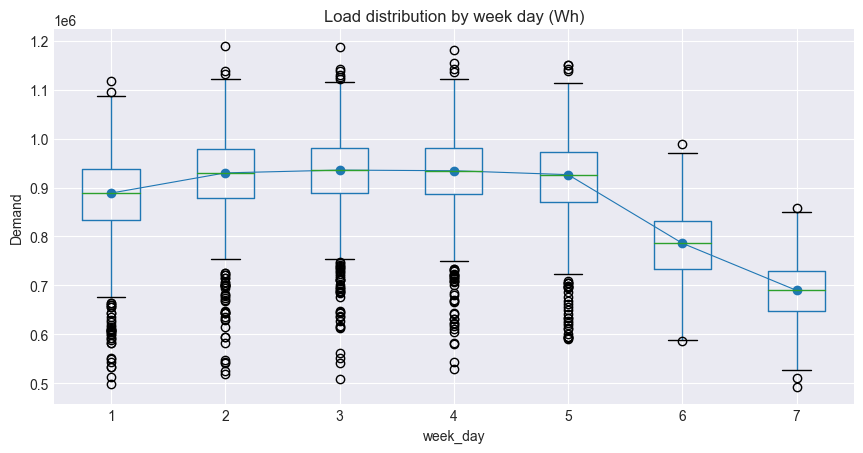

In [ ]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Load', by='week_day', ax=ax)
data.groupby('week_day')['Load'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Load distribution by week day (Wh)')
fig.suptitle('')
plt.show()

The load increases in the mid-days of the week, with minimum in the weekends, as already anticipated.

## Step 2: forecasting

The aim of the second step is to develop a long-term forecasting model for the power load with a 1-year horizon.

### Recursive multi-step forecasting

The recursive multi-step forecasting [ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/autoregresive-forecaster.html) is used, with [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) as regressor. In recursive multi-step forecasting, predicted values from previous time steps are used to forecast the values for the next steps. A window of 1850 days (1850 lags) is used to predict the next day demand (**steps**). Such values are selected rather arbitrarly by trial and error. Maybe an **autocorrelation** analysis might cast some insight on this. The hyperparameters of the regressor are left as default for the moment.

[LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) is a gradient-boosting framework developed by Microsoft, that implements sequential regression trees, where each new tree is trained to correct the errors made by the previous trees.


In [ ]:
# Set the forecast horizon and the lags
# ==============================================================================
steps = 1
lags = 1850

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'Load'])
forecaster


ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [   1    2    3 ... 1848 1849 1850] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1850 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2006-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-22 19:1

A backtesting is performed, that consists in generating a forecast for each observation in the test set. Then the predicted value is compared with the actual one. The mean absolute error (MAE) is used as performance metric. The lower the MAE, the smaller the prediction errors on average. More information are given in the Results section. 

In [ ]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4748
Number of observations used for backtesting: 365
    Number of folds: 365
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-01 00:00:00 -- 2019-01-01 00:00:00  (n=1)
Fold: 1
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-02 00:00:00 -- 2019-01-02 00:00:00  (n=1)
Fold: 2
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-03 00:00:00 -- 2019-01-03 00:00:00  (n=1)
Fold: 3
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-04 00:00:00 -- 2019-01-04 00:00:00  (n=1)
Fold: 4
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-05 00:00:00 

  0%|          | 0/365 [00:00<?, ?it/s]

The MAE is then printed.

In [ ]:
# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 22473.214169529892


One can then plot the predicted values and the actual ones to appreciate the validity of the forecasting.

In [ ]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

Last step in the forecasting is the hyperparameter tuning. A [Bayesian Search](https://skforecast.org/0.11.0/user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search) is performed to find the best setup for the model. Compared to Grid Search and Random Search, Bayesian Search uses information on hyperparameters of previous computed performances to guide the search towards most promising regions. A `bayesian_search_forecaster()` function is used, while the search space bounds are specified in the function `search_space()`.

In [ ]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags, # This value will be replaced in the search
             )

# Lags used as predictors
lags_grid = [lags, [720, 1000, 1500, 1850, 1900, 2000, 2500, 2800, 2900, 3000]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 800, 1500, step=100), # number of decision trees
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),          # max. depth of each  tree
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),        # step size towards the minimum of the loss function
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),       # L1 regularization
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),      # L2 regularization
    } 
    return search_space

The search is then performed (be careful, as it may take some time depending on the machine).

In [ ]:
# Perform the search
# ==============================================================================
results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:, 'Load'],
                                   steps              = steps,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   initial_train_size = len(data[:end_train]),
                                   refit              = False, 
                                   n_trials           = 100,    # Increase for more exhaustive search
                                   random_state       = 123,    # To reproduce results
                                   return_best        = True,   # To return best forecast parameters
                                   n_jobs             = 'auto', # '-1' to use all available cores
                                   verbose            = False,
                                   show_progress      = True
                               )

# Search results
# ==============================================================================
results_search.head(10)

Number of models compared: 200,
         100 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 1848 1849 1850] 
  Parameters: {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.0100786818966835, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
  Backtesting metric: 21579.712314528235



,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21579.712315,1200.0,5.0,0.010079,0.1,0.1
53,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1500, 'max_depth': 5, 'learni...",21601.195430,1500.0,5.0,0.010491,0.1,0.0
83,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21619.435397,1300.0,5.0,0.010407,0.1,0.1
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 5, 'learnin...",21704.180692,800.0,5.0,0.012273,0.1,0.0
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1400, 'max_depth': 5, 'learni...",21749.184954,1400.0,5.0,0.014411,0.1,0.0
82,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21760.170304,1300.0,5.0,0.011119,0.0,0.1
75,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 5, 'learni...",21761.844768,1000.0,5.0,0.023305,0.0,0.2
86,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21770.772120,1300.0,5.0,0.012684,0.0,0.2
98,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21798.823567,1200.0,5.0,0.010171,0.2,0.1
81,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21804.038492,1300.0,5.0,0.010262,0.0,0.1


The best setup is returned and the final model is backtested on the data.

In [ ]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[:,'Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_train]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")

  0%|          | 0/365 [00:00<?, ?it/s]

Backtest error (MAE): 21579.71


As it can be seen, tuning the hyperparameters has returned a lower MAE, i.e., 21579.71 Wh compared to previous 22473.21 Wh. The new plot of the predictions is provided.

In [ ]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

## Results, limitations and future work

The MAE has been used as perfomance metric in this study. This is computed as follows:

$ MAE = \frac{\sum_{i=1}^{N}|y_i - \hat{y}_i|}{N} $ 

where $ N $ is the number of test data, $ y_i $ and $ \hat{y}_i $ are the true and predicted values. The MAE provides a measure of the average magnitude of errors between your predictions and the actual values. A lower MAE indicates smaller errors on average, suggesting that the predictions are closer to the actual values. The MAE is expressed in the same units as the original data, making it interpretable.

In the current case, a MAE of 21579.71 Wh migth be considered acceptable or not depending on the specific application of the current analysis. Such error is at least one order of magnitude lower than the minimum power load in the datasets, i.e., approximately 500k Wh, occurring in April 2019. The percentage error is thus around 4%. From the previous plot, one sees that the minimum and maximum values are not well approximated by the predictions in April and June, respectively. This is seen also in the next figure, showing the magnitude of the residuals with respect to time.

Text(0.5, 1.0, 'Residuals (Wh)')

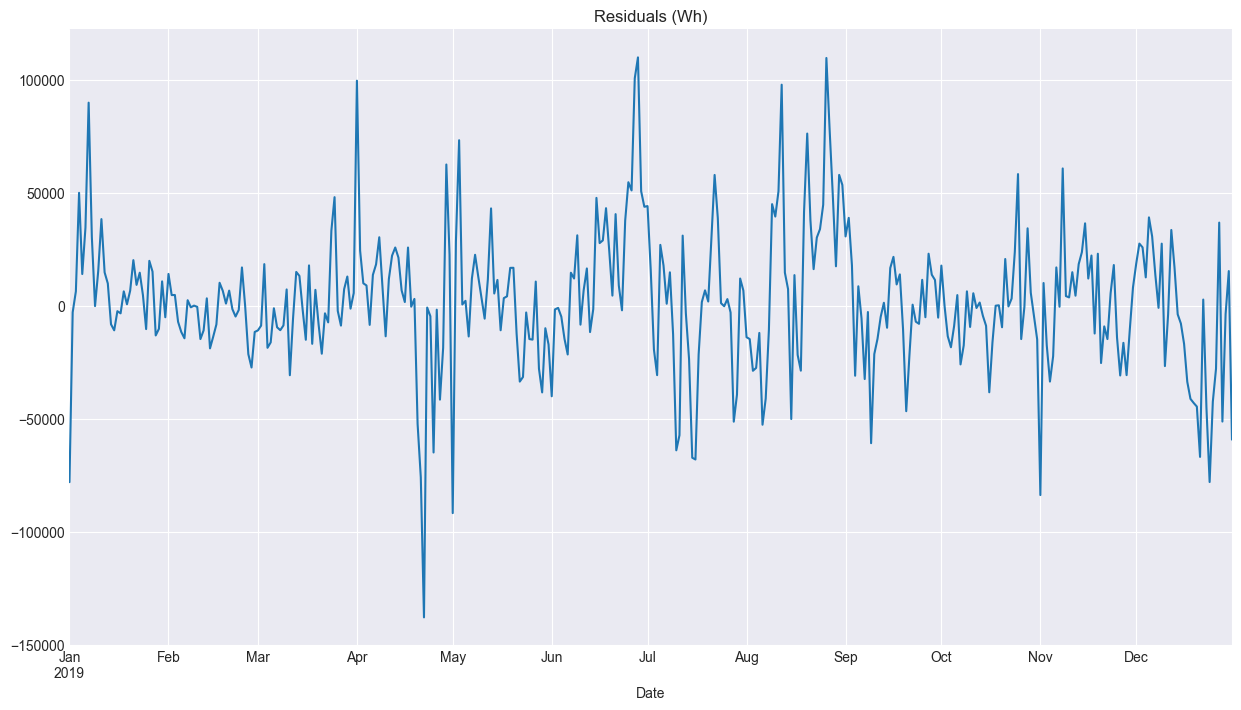

In [ ]:
# Compute the residuals
# ==============================================================================
actual_values = data.loc[start_test:, 'Load']
predicted_values = predictions['pred']
residuals = actual_values - predicted_values


# plot the residuals
fig, ax = plt.subplots(figsize=(15, 8))
residuals.plot(ax=ax, label='Load')
ax.set_title('Residuals (Wh)')


The reson behind this might lie in the magnitude of such minimum and maximum values at April and June, respectively. In particular, the minimum power load in April 2019 is also the global minimum in the whole dataset, thus it might be difficult for the model to predict that value. Similarly, only 4 peaks in June throughout the whole dataset (more than 10 years!) reached similar values to that of June 2019. 

The use of lags and their relations with the performance metric need deeper understanding, maybe testing few more values in the Bayesian search. Finally, more models can be tested to identify the one that is more suited for the application. In addition, adding exogenous variables (e.g., the air temperature and/or humidity) might improve the model.